In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

In [8]:
@njit
def blahut_update(p_x, p_y_given_x, eps=1e-20):
    """
    Blahut algorithm for computing the mutual information between variable X and variable Y.
    The function takes as input:
    - xvec: the values of the random variable X (N-dim array)
    - yvec: the values of the random variable Y (M-dim array)
    - p_x: the probability mass function of X (N-dim array)
    - p_y_given_x: the conditional probability mass function of Y given X (MxN array)
    The function returns as output:
    - I_L: the lower bound to the mutual information (scalar)
    - I_U: the upper bound to the mutual information (scalar)
    - f_kl_new: updated Bayes risk (N-dim array)
    - p_y_new: updated probability mass function of Y (M-dim array)
    - p_x_new: updated probability mass function of X (N-dim array)
    """
    N = len(p_x)
    M = len(p_y_given_x)

    p_y = np.zeros(M) # output dist
    f_kl = np.zeros(N) # Bayes risk
    p_x_new = np.zeros(N) # updated input dist
    for a in range(N):
        for b in range(M):
            p_y[b] += p_y_given_x[b,a]*p_x[a]
            
    for a in range(N):
        for b in range(M):  
            f_kl[a] += p_y_given_x[b,a]*np.log2((p_y_given_x[b,a]+eps)/(p_y[b]+eps))
        p_x_new[a] = p_x[a]*np.exp(f_kl[a]) 

    p_x_new /= p_x_new.sum() # normalize

    p_y_new = np.zeros(M) # updated output dist
    f_kl_new = np.zeros(N) # updated Bayes risk
    I_L = 0 # lower bound to capacity
    for a in range(N):
        for b in range(M):
            p_y_new[b] += p_y_given_x[b,a]*p_x_new[a]
    
    I_U = 0 # upper bound to capacity
    for a in range(N):
        for b in range(M):
            f_kl_new[a] += p_y_given_x[b,a]*np.log2((p_y_given_x[b,a]+eps)/(p_y_new[b]+eps))
        I_L += p_x_new[a]*f_kl_new[a]
        if f_kl_new[a] > I_U:
            I_U = f_kl_new[a]

    return I_L, I_U, f_kl_new, p_x_new

In [9]:
xvec = np.linspace(-1, 1, 500)
yvec = np.linspace(-0.5, 1.5, 500)

In [10]:
### Example Gaussian channel with peak power constraint ###

# noise
@njit
def sigma(xvec): 
    return 0.1
# mean
@njit
def mu(xvec):
    return 1/(1+np.exp(-xvec*5))

@njit(parallel=True)
def fill_p_y_given_x(xvec, yvec, mu, sigma):
    p_y_given_x = np.zeros((len(yvec), len(xvec)))
    for i in prange(len(xvec)):
        x = xvec[i]
        mu_x = mu(x)
        sigma_x = sigma(x)
        for j in range(len(yvec)):
            y = yvec[j]
            p_y_given_x[j, i] = 1/(sigma_x*np.sqrt(2*np.pi)) * np.exp(-(y-mu_x)**2/(2*sigma_x**2))

    for i in prange(len(xvec)):
        col_sum = 0.0
        for j in range(len(yvec)):
            col_sum += p_y_given_x[j, i]
        for j in range(len(yvec)):
            p_y_given_x[j, i] /= col_sum
    return p_y_given_x

In [11]:
p_y_given_x = fill_p_y_given_x(xvec, yvec, mu, sigma)

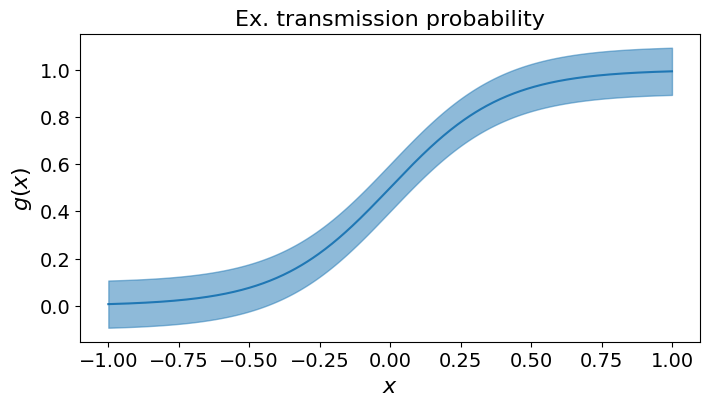

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(xvec, mu(xvec))
ax.fill_between(xvec, mu(xvec) - sigma(xvec), mu(xvec) + sigma(xvec), color='tab:blue', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$g(x)$', fontsize=16)
ax.set_title('Ex. transmission probability', fontsize=16)
plt.show(fig)

In [13]:
p_x = np.ones(len(xvec)) / len(xvec)  # initialise uniform prior

Lower bound: 1.74445933688677 bits
Upper bound: 1.7445593168677396 bits


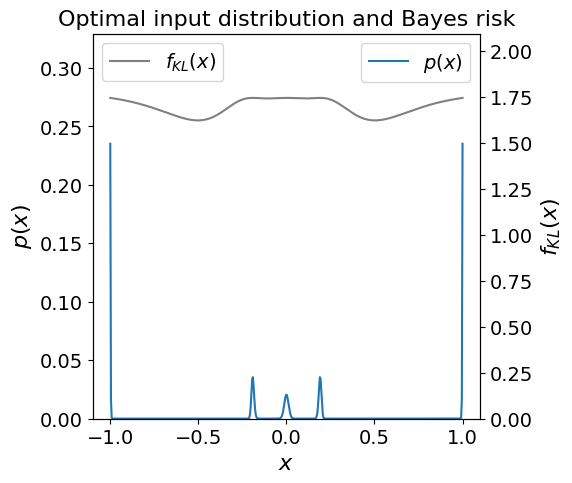

In [14]:
threshold = 1e-4
max_iterations = 10000

for _ in range(max_iterations):
    I_L, I_U, f_kl_new, p_x = blahut_update(p_x, p_y_given_x)
    if I_U - I_L < threshold:
        break

print(f"Lower bound: {I_L} bits")
print(f"Upper bound: {I_U} bits")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(xvec, p_x)
ax.set_ylabel(r"$p(x)$", fontsize=16)
ax.set_xlabel(r"$x$", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim(-0.0001, 1.4*np.max(p_x))

ax_secondary = ax.twinx()
ax_secondary.set_ylabel(r'$f_{KL}(x)$', fontsize=16)
ax_secondary.tick_params(axis='y', which='major', labelsize=14)
ax_secondary.plot(xvec, f_kl_new, color = 'gray')
ax_secondary.set_ylim(0, 1.2*np.max(f_kl_new))

ax.legend([r'$p(x)$', r'$f_{KL}(x)$'], fontsize=14)
ax_secondary.legend([r'$f_{KL}(x)$'], fontsize=14, loc='upper left')

ax.set_title('Optimal input distribution and Bayes risk', fontsize=16)

plt.show(fig)

In [ ]:
K = 5
weights = 1/K
x_positions = np.linspace(-1, 1, K)